## Outline

1. Loading the datasets - Transforming the images
2. VGG-16 with modification to the network head
3. Using pre-trained models - use transfer learning as the deep CNN models are very costly to train
4. Storing intermidiate models - checkpointing the models with lower loss
5. ResNet 
6. Inception v3
7. Exercises

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm_notebook

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 1. Loading the datasets, transforming the datasets and visualizing them

**Image Transform function** - -  Basically used for data augmentation, normalization of the image


transforms.Compose just clubs all the transforms provided to it. So, all the transforms in the transforms.Compose are applied to the input one by one.

Train transforms
1. **transforms.RandomResizedCrop(224)**: This will extract a patch of size (224, 224) from your input image randomly. So, it might pick this path from topleft, bottomright or anywhere in between. So, you are doing data augmentation in this part. Also, changing this value won't play nice with the fully-connected layers in your model, so not advised to change this.
2. **transforms.RandomHorizontalFlip()**: Once we have our image of size (224, 224), we can choose to flip it. This is another part of data augmentation.
3. **transforms.ToTensor()**: This just converts your input image to PyTorch tensor.
4. **transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])**: This is just input data scaling and these values (mean and std) must have been precomputed for your dataset. Changing these values is also not advised.

Link: https://stackoverflow.com/questions/50002543/what-are-transforms-in-pytorch-used-for

Pytorch docs - https://pytorch.org/docs/master/torchvision/transforms.html
 

In [0]:
# transformation of images prior to loading the datasets
# these operations are inline functions

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # each RGB channel normalize to 0.5 mean and 0.5 standard deviation
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size= 16
num_classes = 10

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])
7


## 2. Visualizing the images

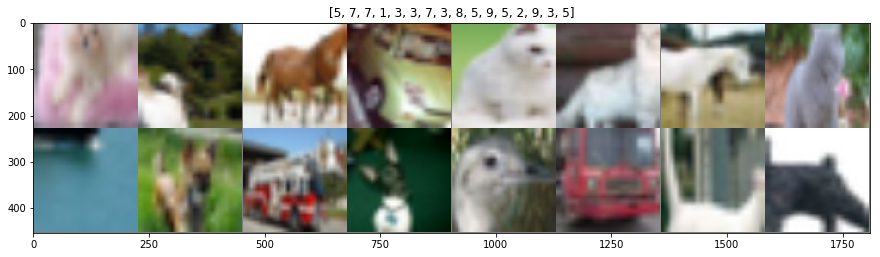

In [0]:
def display_image(image,label):
  img = image.numpy()/2 + 0.5
  img = np.transpose(img, (1,2,0))
  plt.figure(figsize=(15,10))
  plt.imshow(img)
  plt.title(label)
  plt.show()
  
display_image(torchvision.utils.make_grid(images), [x.item() for x in labels])

## 3. VGG-16 Net Model

In [0]:
from torchvision import models

vgg = models.vgg16_bn()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
print(vgg.features[0])
print(vgg.classifier[6])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Linear(in_features=4096, out_features=1000, bias=True)


**How to modify the model  alternatively**

here we are adding 10 classifier instead of the default values

In [0]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features,num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace), Dropout(p=0.5), Linear(in_features=4096, out_features=10, bias=True)]


In [0]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

## 4. Training the VGG -16 net with CIFAR10

Warning: Working with larger batch sizes can actually comsume all the memory in the GPU. Because when we have larger batch size we will have to store more parameters in the GPU while backpropagating. 

In [0]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
vgg  =vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [0]:
def return_accuracy(dataloader,model):
  total = 0
  correct = 0
  for images,labels in tqdm_notebook(dataloader,unit='Mini-Batches',total=len(dataloader)):
    images,labels = images.to(device), labels.to(device)
    prediction = model(images)
    total += labels.size(0)
    correct += torch.sum(torch.argmax(prediction,dim=1) == labels).item()
  return correct/total*100

In [0]:
epochs = 15

for epoch in range(epochs):
  print('Epoch:',epoch)
  iter_no = 0
  for i, data in enumerate(trainloader):  
    # get the inputs from every batch
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad() # zero the parameter gradients
    train_pred = vgg(inputs) # forward pass
    loss_train = loss_fn(train_pred,labels) # compute the loss
    loss_train.backward() # backward pass
    opt.step() # update the weight
    
    # free up the GPU memory - to ensure memory usage is small
    del inputs,labels, train_pred
    torch.cuda.empty_cache()
        
    iter_no += 1
    
    if iter_no % 100 == 0:
      train_accuracy = return_accuracy(trainloader,vgg)
      test_accuracy = return_accuracy(testloader,vgg)
      print('Accuracy on training set:',train_accuracy,' | Accuracy on test set:',test_accuracy)

Epoch: 0


170500096it [02:50, 4039375.47it/s]                               

KeyboardInterrupt: ignored

How to calculate the number of parameters of convolutional neural network

https://stackoverflow.com/questions/28232235/how-to-calculate-the-number-of-parameters-of-convolutional-neural-networks

## 5. Pre-Trained VGG-16 Models

In [0]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth

100%|██████████| 553507836/553507836 [00:20<00:00, 27090476.59it/s]

In [0]:
# set the parameters to no grads for all the 138 milion parameters
for params in vgg.parameters():
  params.requires_grad = False

This pre-trained VGG is trained for ImageNet Dataset which classifies 1000 classes. Our problem here is to predict 10 classes. Hence we will modify the last layer of this model and set that layer as requires_grad such that when we feed in the data, the weight is updated for only the last layer. In other words, the previous parameters are already preloaded and that is not required to be trained and hence we have set them to requires_grad = False. as mentioned in the above cell

In [0]:
# modifying the last layer
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features,num_classes)

vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [0]:
# now set the last layer to requires_grad = True
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg  = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [0]:
import copy

In [0]:
%%time

min_loss = 1000
best_model = vgg

iter_no = 0

for data in tqdm_notebook(trainloader,unit='mini-batches',total=len(trainloader)):
  images,labels = data
  images,labels = images.to(device), labels.to(device)
  
  train_pred = vgg(images)
  loss = loss_fn(train_pred,labels)
  # backward propagation
  loss.backward()
  opt.step()
  opt.zero_grad()
  
  del images,labels, train_pred
  torch.cuda.empty_cache()
  
  iter_no += 1
  
  # checkpointing the model
  if min_loss > loss.item():
    min_loss = loss.item()
    best_model = copy.deepcopy(vgg.state_dict())
    print('Minimum Loss:',min_loss)
  
  if iter_no % 200 == 0:
    print('Iteration:',iter_no,'of',len(trainloader),' | loss =',loss.item())

Minimum Loss: 2.330763816833496
Minimum Loss: 2.1780245304107666
Minimum Loss: 1.6401430368423462
Minimum Loss: 1.6386836767196655
Minimum Loss: 1.5422064065933228
Minimum Loss: 1.4955064058303833
Minimum Loss: 1.397256851196289
Minimum Loss: 1.3591982126235962
Minimum Loss: 1.3002930879592896
Minimum Loss: 1.1117503643035889
Minimum Loss: 0.7388119697570801
Iteration: 200 of 3125  | loss = 1.1334677934646606
Iteration: 400 of 3125  | loss = 1.9340782165527344
Iteration: 600 of 3125  | loss = 2.088750123977661
Iteration: 800 of 3125  | loss = 1.7659209966659546
Iteration: 1000 of 3125  | loss = 1.4166090488433838
Iteration: 1200 of 3125  | loss = 1.7420567274093628
Minimum Loss: 0.6263658404350281
Iteration: 1400 of 3125  | loss = 1.8537523746490479
Iteration: 1600 of 3125  | loss = 2.552797317504883
Iteration: 1800 of 3125  | loss = 2.0303966999053955
Iteration: 2000 of 3125  | loss = 1.5308516025543213
Iteration: 2200 of 3125  | loss = 1.378250241279602
Iteration: 2400 of 3125  | los

Exception ignored in: <bound method tqdm.__del__ of 170500096it [17:41, 4039375.47it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [0]:
vgg.load_state_dict(best_model)
print(return_accuracy(trainloader,vgg))
print(return_accuracy(testloader,vgg))


44.39



44.11


## 6. Pretrained ResNet

https://arxiv.org/abs/1512.03385

In [0]:
resnet = models.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 37816626.21it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for params in resnet.parameters():
  params.requires_grad = False

In [0]:
# modify the last layer 
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features,num_classes)

for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(),lr=0.01)

In [0]:
%%time

min_loss = 1000
best_model = resnet.state_dict()

iter_no = 0

for data in tqdm_notebook(trainloader,unit='mini-batches',total=len(trainloader)):
  images,labels = data
  images,labels = images.to(device), labels.to(device)
  
  train_pred = resnet(images)
  loss = loss_fn(train_pred,labels)
  # backward propagation
  loss.backward()
  opt.step()
  opt.zero_grad()
  
  del images,labels, train_pred
  torch.cuda.empty_cache()
  
  iter_no += 1
  
  # checkpointing the model
  if min_loss > loss.item():
    min_loss = loss.item()
    best_model = copy.deepcopy(resnet.state_dict())
    print('Minimum Loss:',min_loss)
  
  if iter_no % 200 == 0:
    print('Iteration:',iter_no,'of',len(trainloader),' | loss =',loss.item())

Minimum Loss: 1.4296793937683105
Minimum Loss: 0.7462425231933594
Minimum Loss: 0.7208900451660156
Minimum Loss: 0.6823360919952393
Iteration: 200 of 3125  | loss = 1.30055832862854
Iteration: 400 of 3125  | loss = 1.5588045120239258
Minimum Loss: 0.6176875233650208
Iteration: 600 of 3125  | loss = 1.4727096557617188
Iteration: 800 of 3125  | loss = 1.70992112159729
Iteration: 1000 of 3125  | loss = 1.628883719444275
Minimum Loss: 0.4116479456424713
Iteration: 1200 of 3125  | loss = 0.9346876740455627
Iteration: 1400 of 3125  | loss = 1.5537022352218628
Iteration: 1600 of 3125  | loss = 1.2020493745803833
Iteration: 1800 of 3125  | loss = 1.329807162284851
Iteration: 2000 of 3125  | loss = 1.0283374786376953
Iteration: 2200 of 3125  | loss = 1.0577255487442017
Iteration: 2400 of 3125  | loss = 1.2348134517669678
Iteration: 2600 of 3125  | loss = 0.8144305944442749
Iteration: 2800 of 3125  | loss = 1.127776026725769
Iteration: 3000 of 3125  | loss = 1.6019437313079834
CPU times: user 2m

In [0]:
%%time

resnet.load_state_dict(best_model)
print(return_accuracy(trainloader,resnet))
print(return_accuracy(testloader,resnet))

54.013999999999996


53.080000000000005
CPU times: user 3min 19s, sys: 56.5 s, total: 4min 15s
Wall time: 4min 14s


## 7. Pretrained Inception Net

https://arxiv.org/abs/1512.00567

In [0]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:02<00:00, 49910173.93it/s]


In [0]:
print(inception)

In [0]:
for params in inception.parameters():
  params.requires_grad = False

In [0]:
# modify the output and auxillary output as per our dataset
# 1. Output layer
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features,num_classes)

# 2. Auxillary layer
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features,num_classes)

In [0]:
for params in inception.parameters():
  if params.requires_grad:
    print(params.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


**Note: ** The inception model takes 299 by 299 sized images. Hence we need to transform the dataset using torchvision transforms

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(),lr=0.01)

In [0]:
def return_accuracy_inception(dataloader,model):
  total = 0
  correct = 0
  for images,labels in tqdm_notebook(dataloader,unit='Mini-Batches',total=len(dataloader)):
    images,labels = images.to(device), labels.to(device)
    prediction,aux = model(images)
    total += labels.size(0)
    correct += torch.sum(torch.argmax(prediction,dim=1) == labels).item()
  return correct/total*100

In [0]:
%%time

min_loss = 1000
best_model = inception

iter_no = 0

for data in tqdm_notebook(trainloader,unit='mini-batches',total=len(trainloader)):
  images,labels = data
  images,labels = images.to(device), labels.to(device)
  
  train_pred,aux = inception(images)
  loss = loss_fn(train_pred,labels) + 0.3*loss_fn(aux,labels) # adding the 2 loss output
 
  # backward propagation
  loss.backward()
  opt.step()
  opt.zero_grad()
  
  del images,labels, train_pred
  torch.cuda.empty_cache()
  iter_no += 1
  
  # checkpointing the model
  if min_loss > loss.item():
    min_loss = loss.item()
    best_model = copy.deepcopy(inception.state_dict())
    print('Minimum Loss:',min_loss)
  
  if iter_no % 200 == 0:
    print('Iteration:',iter_no,'of',len(trainloader),' | loss =',loss.item())

Minimum Loss: 3.113765239715576
Minimum Loss: 2.959991455078125
Minimum Loss: 2.860480546951294
Minimum Loss: 2.852996826171875
Minimum Loss: 2.851492166519165
Minimum Loss: 2.774010181427002
Minimum Loss: 2.70267391204834
Minimum Loss: 2.589735507965088
Minimum Loss: 2.5196831226348877
Minimum Loss: 2.4514293670654297
Minimum Loss: 2.2925078868865967
Iteration: 200 of 3125  | loss = 2.3295836448669434
Minimum Loss: 2.2442970275878906
Minimum Loss: 2.1420998573303223
Minimum Loss: 2.117684841156006
Minimum Loss: 2.0908470153808594
Minimum Loss: 2.014836311340332
Minimum Loss: 1.9942317008972168
Minimum Loss: 1.920752763748169
Iteration: 400 of 3125  | loss = 2.5146751403808594
Minimum Loss: 1.8869223594665527
Minimum Loss: 1.7287977933883667
Minimum Loss: 1.6954327821731567
Iteration: 600 of 3125  | loss = 1.9000883102416992
Minimum Loss: 1.6293995380401611
Minimum Loss: 1.562544584274292
Minimum Loss: 1.5049777030944824
Iteration: 800 of 3125  | loss = 1.8945822715759277
Minimum Loss:

In [0]:
%%time
inception.load_state_dict(best_model)
print(return_accuracy_inception(trainloader,inception))
print(return_accuracy_inception(testloader,inception))

47.002


46.29
CPU times: user 10min 13s, sys: 4min 48s, total: 15min 2s
Wall time: 15min
